In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import seaborn as sns
import pandas as pd
from pathlib import Path
from utils import *
from inception import *
from res2net import *
from models import *
from ucr import *
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import fastai
from fastai.vision import *

In [3]:
DATAPATH = Path.cwd()/'Univariate_arff'

In [4]:
sorted(list(DATAPATH.iterdir()))

[PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ACSF1'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Adiac'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteX'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteY'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/AllGestureWiimoteZ'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/ArrowHead'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BME'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/Beef'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BeetleFly'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/BirdChicken'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/CBF'),
 PosixPath('/home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/C

In [5]:
task = 'OliveOil'
df_train, df_test = load_df(DATAPATH, task)

Loading files from: /home/tc256760/Documents/TimeSeries_fastai/Univariate_arff/OliveOil


In [6]:
num_classes = df_train.target.nunique(); num_classes

4

# DL

In [7]:
x_train, y_train, x_test, y_test = process_dfs(df_train, df_test)

In [8]:
x_train.shape, x_test.shape

((30, 570), (30, 570))

In [9]:
tr_ds, val_ds = to_TDS(x_train, y_train), to_TDS(x_test, y_test)

In [10]:
db = create_databunch(tr_ds, val_ds, 32)

Testing dims at input/output

In [11]:
for tx, ty in db.train_dl:
    print(tx.shape, ty.shape)

torch.Size([30, 1, 570]) torch.Size([30])


## Res2Net

In [12]:
model = Res2Net(Res2Block, [3, 4, 6, 3], c_in=1, num_classes=num_classes, scale=4).cuda(); model

Res2Net(
  (conv1): Sequential(
    (0): Conv1d(1, 32, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (1): Mish()
    (2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2): Sequential(
    (0): Conv1d(32, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): Mish()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
    (1): Mish()
    (2): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Res2Block(
      (conv1): Conv1d(64, 104, kernel_size=(1,), stride=(1,), bias=False)
      (bn1): BatchNorm1d(104, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (pool): AvgPool1d(kernel_size=(3,), stride=(1,)

In [13]:
tx.shape

torch.Size([30, 1, 570])

In [14]:
model(tx).shape

torch.Size([30, 4])

In [15]:
learn_res = fastai.basic_train.Learner(db, 
                                       model, 
                                       loss_func=CrossEntropyFlat(), 
                                       metrics=[accuracy],
                                       wd=1e-2).mixup()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-05
Min loss divided by 10: 1.00E-04


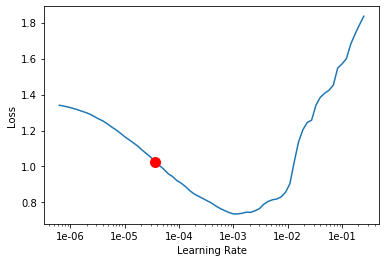

In [16]:
learn_res.lr_find(); learn_res.recorder.plot(suggestion=True)

In [17]:
learn_res.fit_one_cycle(100, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.357518,1.386460,0.166667,00:00
1,1.230918,1.378585,0.166667,00:00
2,1.134581,1.374351,0.166667,00:00
3,1.035210,1.375428,0.166667,00:00
4,0.976156,1.372788,0.400000,00:00
5,0.914095,1.371478,0.400000,00:00
6,0.865272,1.373141,0.400000,00:00
7,0.801660,1.377514,0.400000,00:00
8,0.744748,1.379484,0.400000,00:00
9,0.707056,1.370602,0.400000,00:00


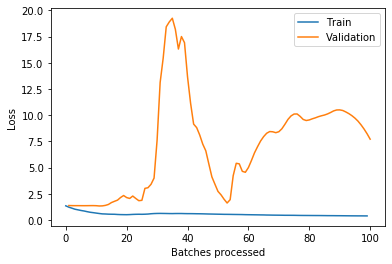

In [18]:
fig = learn_res.recorder.plot_losses(return_fig=True)

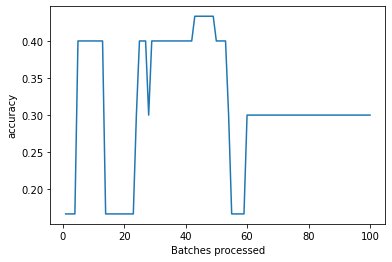

In [21]:
learn_res.recorder.plot_metrics()

In [20]:
fig.savefig('Olive.png')

In [17]:
learn_res.fit_one_cycle(100, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.280489,1.326557,0.400000,00:00
1,1.534013,1.308327,0.400000,00:00
2,1.452713,1.346000,0.400000,00:00
3,1.425002,1.564094,0.133333,00:00
4,1.375142,1.666899,0.133333,00:00
5,1.288842,1.683750,0.166667,00:00
6,1.205281,1.706164,0.166667,00:00
7,1.153635,1.969936,0.133333,00:00
8,1.108979,3.526427,0.133333,00:00
9,1.058013,5.289832,0.133333,00:00


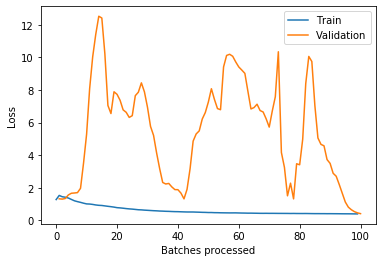

In [18]:
fig = learn_res.recorder.plot_losses(return_fig=True)

In [19]:
fig.savefig('Train_Val.png')

In [19]:
p, t = learn_res.get_preds()

In [20]:
accuracy(p,t)

tensor(0.7227)

In [21]:
def get_cm(p, t): return confusion_matrix(t, p.softmax(dim=1).argmax(1))

Confusion Matrix

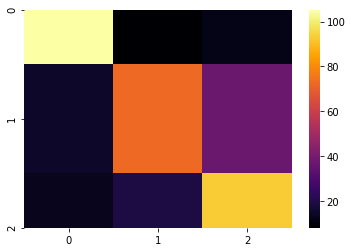

In [22]:
sns.heatmap(get_cm(p,t), cmap='inferno')